# Pattern Recognition 2019 - 2020: Lab 2

#### Christos Lamprakos, 03002910

### Step 1
First, ```praat``` was installed according to the exercise description. Files ```onetwothree1.wav``` and ```onetwothree8.wav``` were then read with the program. Below the respective waveforms and spectrograms are illustrated, along with the pitches and the formants. Selections of phonemes were taken for the requested measurements.

![1](./figs/1_spec.png)
![2](./figs/2_spec.png)

The following data were then collected:

- onetwothree1.wav (male speaker, top figure)
    - 'a' 
        - pitch: 134.9 Hz
        - 1st formant: 712.36 Hz
        - 2nd formant: 1094.14Hz
        - 3rd formant: 2213.3 Hz
    - 'ou' 
        - pitch: 129.3 Hz
        - 1st formant: 400.5 Hz
        - 2nd formant: 1761.8 Hz
        - 3rd formant: 2353.4 Hz
    - 'ee'
        - pitch: 130.9 Hz
        - 1st formant: 402.9 Hz
        - 2nd formant: 1862.3 Hz
        - 3rd formant: 2294 Hz

- onetwothree8.wav (female speaker, bottom figure)
    - 'a' 
        - pitch: 179.9 Hz
        - 1st formant: 798.5 Hz
        - 2nd formant: 1416.9 Hz
        - 3rd formant: 2842 Hz
    - 'ou' 
        - pitch: 187.7 Hz
        - 1st formant: 332.8 Hz
        - 2nd formant: 1740.4 Hz
        - 3rd formant: 2683.2 Hz
    - 'ee'
        - pitch: 179.7 Hz
        - 1st formant: 400.7 Hz
        - 2nd formant: 2137 Hz
        - 3rd formant: 2792.4 Hz

> ***ATTENTION:*** Based on [this][tut] tutorial, the maximum formants for the male and female speakers were set to 5000 and 5500 Hz respectively.

The male speaker's pitch is lower than the female's for all vowels. This can also be deduced from the higher oscillation rate in the female speaker's waveform.

In most of the cases, the difference between the 2 speakers' formants increases with the formant index. The second and third formants of the female speaker are higher than their male counterparts.

The segments corresponding to each vowel were not picked with a systematic way. Both the pitch and the formants depend on calculations which with their turn depend on parameters that were not configured (in any other way than ```praat```'s any automatic process). Thus the results should be taken with a grain of salt.

>***HYPOTHESIS:*** A machine learning approach could leverage the data itself in order to resolve accuracy problems due to lack of expertise. Theoretical knowledge as regards pitch, formants etc. would then be of value only during the **interpretation**, not the **extraction** of the results.

### Rest Steps Preamble
For the rest of the steps, ```python``` was used. The code cell below includes all related imports. Data was read with ```librosa``` and represented with ```numpy``` arrays, ```pytplot``` was used for visualization. The custom-made ```ToolConfig``` class is of mostly typical nature:

```python
class ToolConfig ():
    def __init__ (self):
        self.one = './data/onetwothree1.wav'
        self.two = './data/onetwothree8.wav'
        self.digits_path = './data/digits'
```

[tut]: <https://www.gouskova.com/2016/09/03/praat-tutorial/#Annotating_an_audio_file_with_TextGrids>

In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from config import ToolConfig
from src import tool, sklearn_classifiers, datautilus
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import NuSVC
from sklearn.neighbors import KNeighborsClassifier

conf = ToolConfig ()
sns.set ()

Last but not least, before anything else, a loading and plotting of the alreadyshown waveforms was done with ```librosa```, just to ensure that all works well.

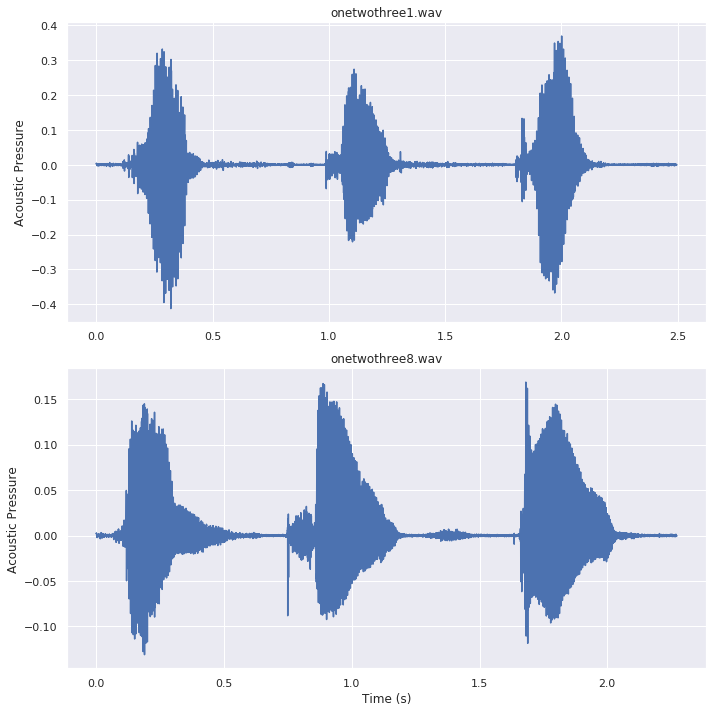

In [2]:
x, fr = librosa.load (conf.one)
x_time = np.linspace (0, (x.size - 1) / fr, x.size)
y, fr2 = librosa.load (conf.two)
y_time = np.linspace (0, (y.size - 1) / fr2, y.size)
fig = plt.figure (figsize = (10, 10))
ax1 = fig.add_subplot (211)
ax1.plot (x_time, x)
ax1.set_title ('onetwothree1.wav')
ax1.set_ylabel ('Acoustic Pressure')
ax2 = fig.add_subplot (212)
ax2.plot (y_time, y)
ax2.set_title ('onetwothree8.wav')
ax2.set_ylabel ('Acoustic Pressure')
ax2.set_xlabel ('Time (s)')
fig.tight_layout ()
plt.show ()

### Step 2
The following functions were implemented:

```python
def nameToFacts (fileName):
    """
    This function returns in int form the parsed results of sound
    files named like 'six2.wav'.
    """
    valText = fileName[:fileName.find ('.')]
    digIdx = valText.find ('1' or '2' or '3' or '4' or '5' or '6' \
                           or '7' or '8' or '9')
    digString = valText[:digIdx]
    speakNum = int (valText[digIdx:])
    return speakNum, {
                        'one' :     1,
                        'two' :     2,
                        'three' :   3,
                        'four' :    4,
                        'five' :    5,
                        'six' :     6,
                        'seven' :   7,
                        'eight' :   8,
                        'nine' :    9
                     }.get (digString)

def dataParser (path):
    """
    This function parses all files in the directory specified by
    the path input variable. It is assumed that all said files are
    valid .wav files.
    """
    waves = []
    rates = []
    digits = []
    speakers = []
    files = [f for f in listdir (path) if isfile (join (path, f))]
    for i in range (len (files)):
        #Keep both the signals themselves, and the sampling rates.
        sig, rate = librosa.load (join (path, files[i]))
        waves.append (sig)
        rates.append (rate)
        jspeak, jdig = nameToFacts (files [i])
        digits.append (jdig)
        speakers.append (jspeak)
    print ('Parsing complete! ', len (waves), ' files in total.')
    return waves, np.array (digits), np.array (speakers), rates
```

>All written functions are contained in the ```tool``` moodule of the ```src``` package submitted with this report

In [3]:
wavs, digits, speakers, rates = tool.dataParser (conf.digits_path)

Parsing complete!  133  files in total.


### Step 3

To compute the MFCC's, ```librosa.feature.mfcc``` was used. The important parameters here were ```sr``` (sampling rate), ```n_mfcc``` (number of features), ```win_length``` (length of window) and ```hop_length``` (overlap control).

Particularly as regards the overlap, ```hop_length``` controls the number of samples between adjacent Short Time Fourier Transforms of the signal. Thus, the requirements of the exercise description (window length, overlap) have to be translated in sample numbers.

Also,```librosa.feature.delta``` was used for the deltas.

All of the above were packed in the following function. Acting proactively, options for computing deltas and MFSC's instead of MFCC's were included:

```python
def featFactory (wavs, rates, win_sec = 25e-3, ov_sec = 10e-3, \
                 calc_deltas = True, mfsc = False):
    """
    This function extracts features from wavs. Rates are used to ensure proper
    calibration of the window and overlap parameters. By default, MFCC with
    deltas are calculated.
    """
    feats = []
    deltas = []
    deltas2 = []
    for i in range (len (wavs)):
        win = round (win_sec * rates[i])
        hop = round ((win_sec - ov_sec) * rates[i])
        if mfsc == False:
            feats.append (librosa.feature.mfcc (wavs[i], sr = rates[i],     \
                          #by default, librosa returns features as rows. We take
                          #the transpose to have them as columns.
                          n_mfcc = 13, win_length = win, hop_length = hop).T)
        else:             #melspectrogram is used to bypass the DCT performed by
                          #mfcc
            feats.append (librosa.feature.melspectrogram (wavs[i], sr = rates[i],
                          win_length = win, hop_length = hop, n_mels = 13).T)
        if calc_deltas:
            deltas.append (librosa.feature.delta (feats[i].T).T)
            deltas2.append (librosa.feature.delta (feats[i].T, order = 2).T)
    return feats, deltas, deltas2
```

In [4]:
feats, deltas, deltas2 = tool.featFactory (wavs, rates)

Now the features for all of the sound files are saved in the lists above. Note that on the one hand, using lists is not so efficient, but the different signal sizes do not leave us with a more flexible choice.

### Step 4
Due to the large number of figures, a wrapping function for the histogram plotting was written:

```python
def histPlotter (n1, feature, feats, digits, speakers):
    """
    This function draws the histograms of a certain feature of
    a certain digit across all speakers.
    """
    fig = plt.figure (figsize = (10, 10))
    fig_idx = 1
    sigslice = [feats[i][feature - 1, :] for i in range (len (feats)) if digits[i] == n1]
    speakslice = speakers[digits == n1]
    for i in range (len (sigslice)):
        ax = fig.add_subplot (4, 4, fig_idx)
        ax.hist (sigslice[i])
        ax.set_title ('Speaker ' + str (speakslice[i]))
        fig_idx += 1
    fig.tight_layout ()
    plt.show ()
```

>My student number is 03002910, which translates to n1 = 1, n2 = 2

The function was then called sequentially in order to provide the requested output. First, for the first feature of digit 1:


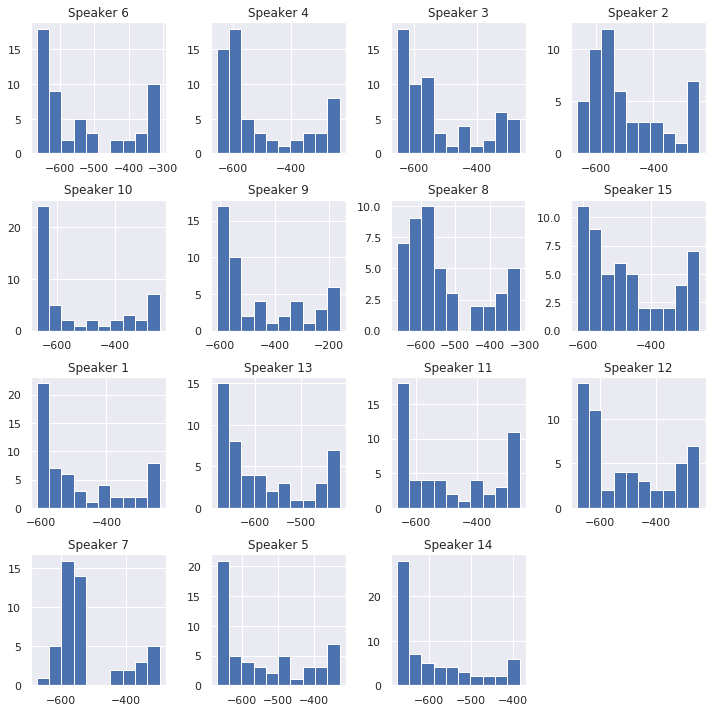

In [5]:
tool.histPlotter (1, 1, feats, digits, speakers)   

Then, for the second feature of digit 1:

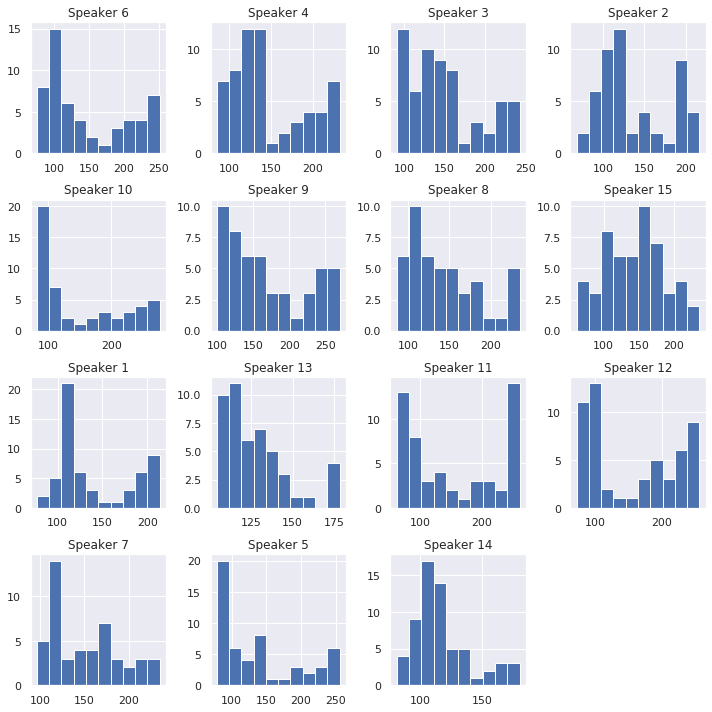

In [6]:
tool.histPlotter (1, 2, feats, digits, speakers) 

Then, for the first feature of digit 2:

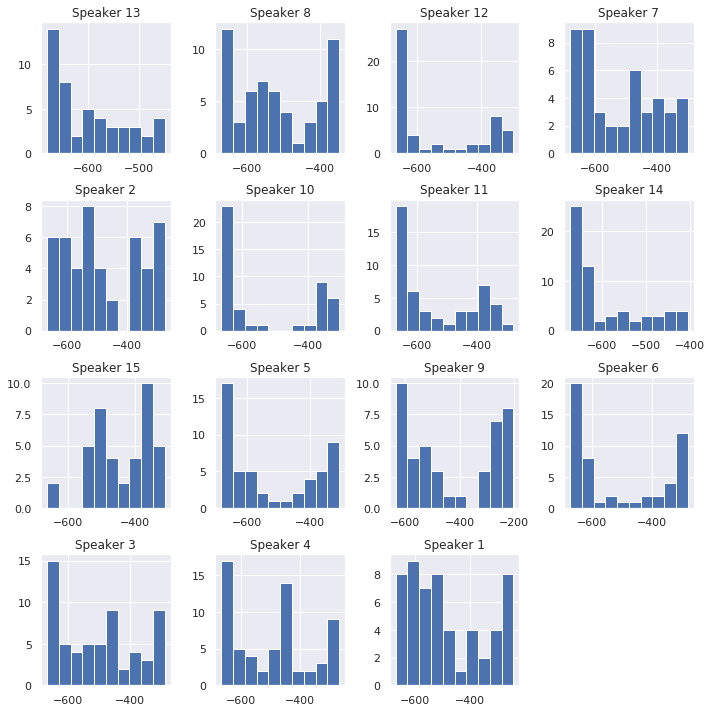

In [7]:
tool.histPlotter (2, 1, feats, digits, speakers) 

And finally, for 2's second feature:

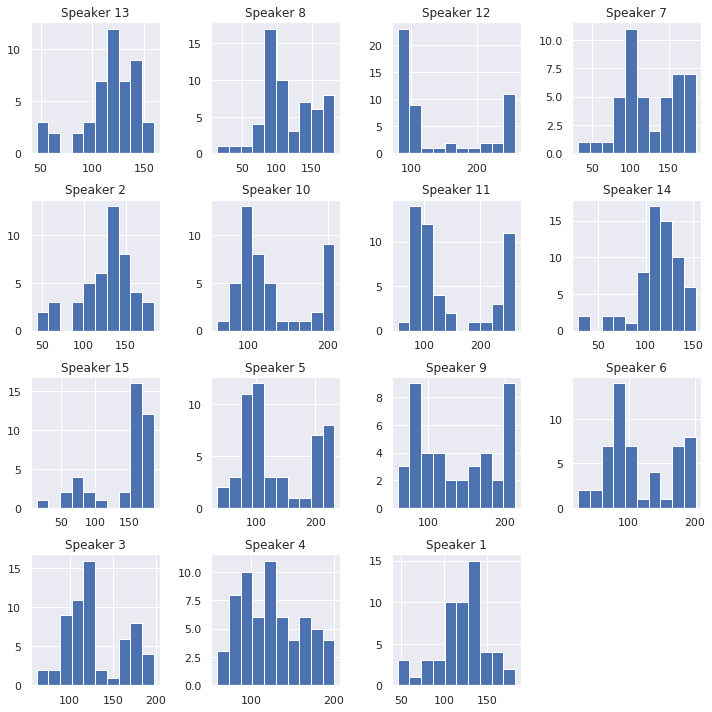

In [8]:
tool.histPlotter (2, 2, feats, digits, speakers) 

It would not be reasonable to call the information of these histograms useful or not, just by examining them with one's eyes. A stable result across all figures is that each feature has approximately the same range of values regardless of the speaker. Take the last cluster as an example, where all bins reside in a neighborhood largely defined by $[50, 200]$. A weaker observation is that of largely repeated peaks: in the same cluster, a neighborhood around value $100$ demonstrates a maximum frequency in most of the speakers.

Next, we have to compare MFCC's and MFSC's extracted on versions of $n_1$ and $n_2$ for 2 different speakers. We use the already presented ```featFactory``` function to compute the MFSC's. We then randomly choose 2 different speakers. Then, given the speakers and the digits of interest, we slice the corresponding features out.

```numpy.corrcoef``` was used for the heatmaps, since the features are **not** normalized at this point.

First random speaker:  2
Second random speaker:  6
Speakers OK! Exiting...


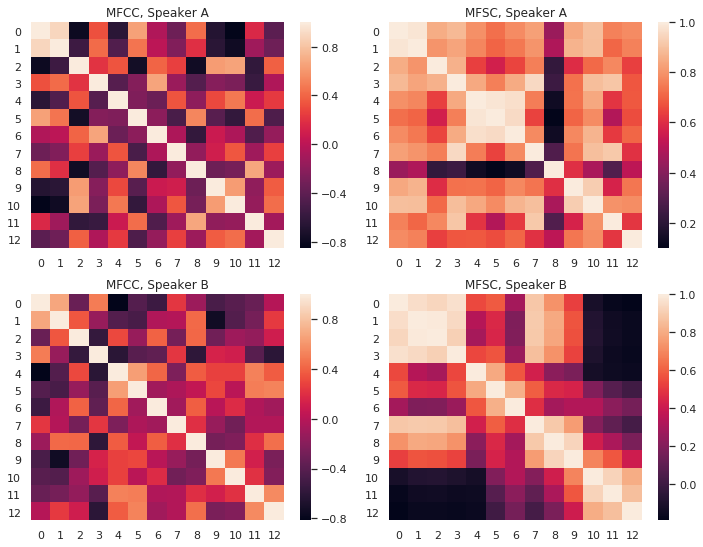

In [9]:
#Extract features...
mfsc_feats, d1, d2 = tool.featFactory (wavs, rates, mfsc = True)

#Pick 2 different speakers at random.
while True:
    speak_A = np.random.randint (1, 15)
    print ('First random speaker: ', speak_A)
    speak_B = np.random.randint (1, 15)
    print ('Second random speaker: ', speak_B)
    if speak_A != speak_B:
        print ('Speakers OK! Exiting...')
        break
    else:
        print ('Same speakers chosen! Trying again...')
        continue
        
#For each n1, n2 and for each speaker, slice out the corresponding feature series.
n1_A_mfcc = feats[np.where (speakers[digits == 1] == speak_A)[0][0]]
n1_A_mfsc = mfsc_feats[np.where (speakers[digits == 1] == speak_A)[0][0]]
n2_A_mfcc = feats[np.where (speakers[digits == 2] == speak_A)[0][0]]
n2_A_mfsc = mfsc_feats[np.where (speakers[digits == 2] == speak_A)[0][0]]
n1_B_mfcc = feats[np.where (speakers[digits == 1] == speak_B)[0][0]]
n1_B_mfsc = mfsc_feats[np.where (speakers[digits == 1] == speak_B)[0][0]]
n2_B_mfcc = feats[np.where (speakers[digits == 2] == speak_B)[0][0]]
n2_B_mfsc = mfsc_feats[np.where (speakers[digits == 2] == speak_B)[0][0]]

#Compute normalized covariance matrices for all the above:
n1Ac = np.corrcoef (n1_A_mfcc, rowvar = False)
n1As = np.corrcoef (n1_A_mfsc, rowvar = False)
n1Bc = np.corrcoef (n1_B_mfcc, rowvar = False)
n1Bs = np.corrcoef (n1_B_mfsc, rowvar = False)
n2Ac = np.corrcoef (n2_A_mfcc, rowvar = False)
n2As = np.corrcoef (n2_A_mfsc, rowvar = False)
n2Bc = np.corrcoef (n2_B_mfcc, rowvar = False)
n2Bs = np.corrcoef (n2_B_mfsc, rowvar = False)

fig = plt.figure (figsize = (10, 15))
ax1 = fig.add_subplot (4, 2, 1)
ax1 = sns.heatmap (n1Ac)
ax1.set_title ('MFCC, Speaker A')
ax2 = fig.add_subplot (4, 2, 2)
ax2 = sns.heatmap (n1As)
ax2.set_title ('MFSC, Speaker A')
ax1 = fig.add_subplot (4, 2, 3)
ax1 = sns.heatmap (n1Bc)
ax1.set_title ('MFCC, Speaker B')
ax2 = fig.add_subplot (4, 2, 4)
ax2 = sns.heatmap (n1Bs)
ax2.set_title ('MFSC, Speaker B')
fig.tight_layout ()
plt.show ()

The figures above are for $n_1$. Moving on to $n_2$:

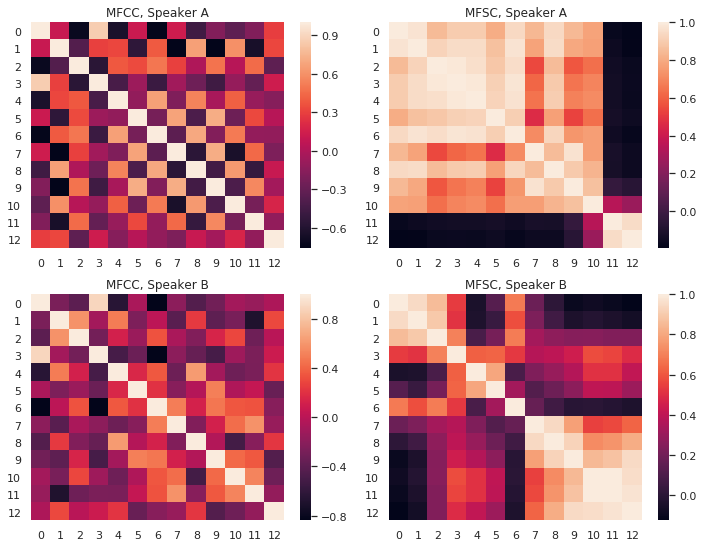

In [10]:
fig = plt.figure (figsize = (10, 15))
ax1 = fig.add_subplot (4, 2, 1)
ax1 = sns.heatmap (n2Ac)
ax1.set_title ('MFCC, Speaker A')
ax2 = fig.add_subplot (4, 2, 2)
ax2 = sns.heatmap (n2As)
ax2.set_title ('MFSC, Speaker A')
ax1 = fig.add_subplot (4, 2, 3)
ax1 = sns.heatmap (n2Bc)
ax1.set_title ('MFCC, Speaker B')
ax2 = fig.add_subplot (4, 2, 4)
ax2 = sns.heatmap (n2Bs)
ax2.set_title ('MFSC, Speaker B')
fig.tight_layout ()
plt.show ()

Based on the above, we deduce the following:
- MFSC features are quite unpredictable and correlated.
- MFCC features are more stable and independent.
    - thus from a pattern recognition perspective, MFCC's would achieve higher performance.
   
### Step 5
The following function was implemented in order to merge all requested features:

```python
def featCompression (feats, deltas, deltas2):
    """
    Returns augmented feature vectors for all cases.
    """
    feats_total = np.zeros (78)
    for i in range (len (feats)):
        row_total = np.array ([])
        feat_mean = np.mean (np.array (feats[i]), axis = 0)
        delt_mean = np.mean (np.array (deltas[i]), axis = 0)
        delt2_mean = np.mean (np.array (deltas2[i]), axis = 0)
        feat_std = np.std (np.array (feats[i]), axis = 0)
        delt_std = np.std (np.array (deltas[i]), axis = 0)
        delt2_std = np.std (np.array (deltas2[i]), axis = 0)
        row_total = np.hstack ((feat_mean, feat_std, delt_mean, delt_std, \
                                delt2_mean, delt2_std))
        feats_total = np.vstack ((feats_total, row_total))
    return feats_total[1:, :]
```
Below the features are generated through ```featCompression```. Then the requested scatter plots are plotted.

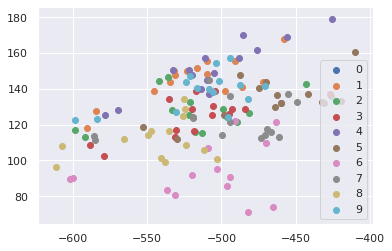

In [11]:
compFeats = tool.featCompression (feats, deltas, deltas2)
fig = plt.figure (figsize = (6, 4))
for i in range (10):
    plt.scatter (compFeats[digits == i][:, 0], compFeats[digits == i][:, 1], label = str (i))
plt.legend (loc = 'best')
plt.show ()

The above figure shows some very loose clustering of the 2 features, but also serious overlap between the 10 classes. This is expected, considering we are viewing mere mean values.

### Step 6
For PCA decomposition, ```scikit-learn``` is used. In the figures below, scatter plots for 2 and 3 final components are shown. A comparison between them and the previous scatter plot would be meaningless, since we were then looking at 'isolated' features that have, in this step, merged with the rest during the decomposition.

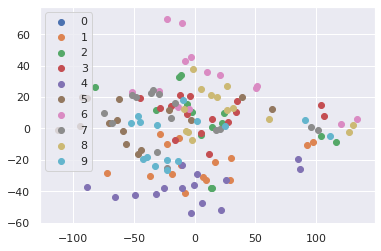

In [12]:
pca_obj = PCA (n_components = 2)
X = pca_obj.fit_transform (compFeats)
fig = plt.figure (figsize = (6, 4))
for i in range (10):
    plt.scatter (X[digits == i][:, 0], X[digits == i][:, 1], label = str (i))
plt.legend (loc = 'best')
plt.show ()

A loose-but-inconclusive clustering can also be observed in the above figure. As for the figure below, it **could** contribute in separating the clusters in horizontal planes, but only with testing would a meaningful discussion be feasible. 

>Still, PCA of statistically aggregated spectral features seems extremely weak for a speech recognition task.

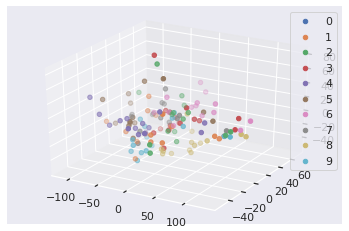

In [13]:
pca_obj_2 = PCA (n_components = 3)
Y = pca_obj_2.fit_transform (compFeats)
fig = plt.figure (figsize = (6, 4))
ax = fig.add_subplot (111, projection = '3d')
for i in range (10):
    ax.scatter (Y[digits == i][:, 0], Y[digits == i][:, 1], Y[digits == i][:, 2], label = str (i))
plt.legend (loc = 'best')
plt.show ()

As regards the new variances, we print the explained variance ratios of the 2 decompositions. We see that in the first case, the components explain ~70% of the total variance, while in the second case the percentage increases at ~80%. Consequently, if a classifier used the decomposed representations, it would miss out on a substantial amount of information.

In [14]:
print (pca_obj.explained_variance_ratio_)
print (pca_obj_2.explained_variance_ratio_)

[0.58210541 0.12074877]
[0.58210541 0.12074877 0.10961696]


### Step 7
A preprocessing step is performed for data standardization. Then scikit-learn's ```train_test_split``` is used for creating a training and a test batch. After that, we perform 10-fold cross validation on:
- Lab 1's Naive Bayes classifier
- sklearn's Naive Bayes implementation
- Lab 1's euclidean classifier
- an SVM with RBF kernel
- a 3 nearest neighbors classifier

In [15]:
scaler = StandardScaler ()
scaledFeats = scaler.fit_transform (compFeats)

X_train, X_test, y_train, y_test = train_test_split (scaledFeats, digits, test_size = 0.3)

customB = sklearn_classifiers.NaiveBayesClassifier ()
scoreB = cross_validate (customB, compFeats, digits, cv = 5)
print ('Lab 1 Bayesian Classifier scored', 100 * np.mean (scoreB['test_score']), '% in 10-fold cross-calidation.')

vanillaB = GaussianNB ()
scoreVB = cross_validate (vanillaB, compFeats, digits, cv = 5)
print ('sklearn Bayesian Classifier scored', 100 * np.mean (scoreVB['test_score']), '% in 10-fold cross-calidation.')

euclid = sklearn_classifiers.EuclideanClassifier ()
scoreEC = cross_validate (euclid, compFeats, digits, cv = 5)
print ('Lab 1 Euclidean Classifier scored', 100 * np.mean (scoreEC['test_score']), '% in 10-fold cross-calidation.')

svm = NuSVC (kernel = 'rbf', gamma = 'scale')
scoreSVM = cross_validate (svm, compFeats, digits, cv = 5)
print ('RBF SVM scored', 100 * np.mean (scoreSVM['test_score']), '% in 10-fold cross-calidation.')

neighbors = KNeighborsClassifier (n_neighbors = 3, algorithm = 'ball_tree')
scoreNN = cross_validate (neighbors, compFeats, digits, cv = 5)
print ('3-NN scored', 100 * np.mean (scoreNN['test_score']), '% in 10-fold cross-calidation.')

Lab 1 Bayesian Classifier scored 63.911111111111104 % in 10-fold cross-calidation.
sklearn Bayesian Classifier scored 63.911111111111104 % in 10-fold cross-calidation.
Lab 1 Euclidean Classifier scored 50.39999999999999 % in 10-fold cross-calidation.
RBF SVM scored 72.35555555555555 % in 10-fold cross-calidation.
3-NN scored 51.318518518518516 % in 10-fold cross-calidation.


The SVM proves to achieve the highest performance on the task. The 2 Bayesian classifiers achieve the same performance, as was expected. The 3 nearest neighbors and the euclidean classifier perform very closely, indicating that the data are indeed clustered through the selected features (but the clustering is correct only half of the time).

## Step 8
We will randomly generate 100 sequences of sines and cosines. Since both of the signals have frequency $f = 40 Hz$, they also have period $T = {1 \over 40} s$. That is, after randomly picking a starting point $t_s$ in the $[0, T]$ range, we match it with an ending point $t_e = t_s + T = t_s + {1 \over 40} s$. All this is done by the following function:

```python
def sinData (f, N, points, P):
    """
    Returns N input-output pairs of points-length sines and cosines of frequency
    f. The signals span P multiples of their periods.
    """
    #Compute oscillation periods.
    T = 1 / f
    #Generate N random starting points.
    start = np.random.rand (N) * T
    #Compute sines and cosines in all intervals.
    s_data = np.array ([])
    c_data = np.array ([])
    for i in range (N):
        s_slice = np.sin (2 * np.pi * f * np.linspace (start[i],        \
                  start[i] + P * T, points))
        c_slice = np.cos (2 * np.pi * f * np.linspace (start[i],        \
                  start[i] + P * T, points))
        if i == 0:
            s_data = s_slice
            c_data = c_slice
        else:
            s_data = np.vstack ((s_data, s_slice))
            c_data = np.vstack ((c_data, c_slice))
    return s_data, c_data
```
Below the sequences are generated and a randomly chosen pair is plotted.

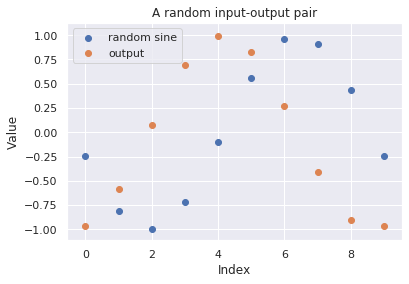

In [16]:
X, y = tool.sinData (40, 100, 10, 1)
t = np.arange (10)
idx = np.random.randint (0, 100)
fig = plt.figure ()
plt.scatter (t, X[idx, :], label = 'random sine')
plt.scatter (t, y[idx, :], label = 'output')
plt.xlabel ('Index')
plt.ylabel ('Value')
plt.title ('A random input-output pair')
plt.legend (loc = 'best')
plt.show ()

Do we need all created sequences for training our network? Certainly the ideal outcome would be to generate arbitrary-length cosines with arbitrary-length sines as input. Our choice of sampling the signals in intervals equal with their period ensures that all the required information is captured. Well, just for the sake of a beginner's curiosity, we will first attempt to achieve the ideal outcome with only one sequence.

So let's create and train an RNN using ```pytorch```. Our first step is to ensure that we have a functional model class at hand. We implement the ```dummyRNN``` class as seen below, and then use it to produce the sequential output. We also visualize the results.

```python
class DummyRNN (torch.nn.Module):
    def __init__ (self, input_size=1, hidden_layer_size=10, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = torch.nn.RNN (input_size, hidden_layer_size)
        self.linear = torch.nn.Linear (hidden_layer_size, output_size)
        self.hidden_cell = torch.zeros (1, 1, self.hidden_layer_size)

    def forward (self, input_seq):
        seqNum = input_seq.view (-1, 1, 10).shape[0]
        seqLength = input_seq.view (-1, 1, 10).shape[-1]
        pred = torch.zeros (seqNum, 1, seqLength)
        for s in range (seqNum):
            for i in range (seqLength):
                rnn_out, self.hidden_cell = self.rnn (input_seq.view        \
                                            (seqNum, 1, seqLength)[s][0][i] \
                                            .view (1, 1, -1), self.hidden_cell)
                pred[s][0][i] = self.linear (self.hidden_cell)
        return pred
```

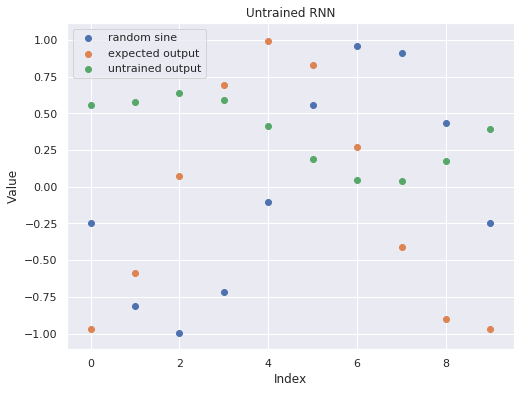

In [17]:
import torch
from src import pytorch_stuff as pt
import numpy as np

class DummyRNN (torch.nn.Module):
    def __init__ (self, input_size=1, hidden_layer_size=10, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.rnn = torch.nn.RNN (input_size, hidden_layer_size)
        self.linear = torch.nn.Linear (hidden_layer_size, output_size)
        self.hidden_cell = torch.zeros (1, 1, self.hidden_layer_size)

    def forward (self, input_seq):
        seqNum = input_seq.view (-1, 1, 10).shape[0]
        seqLength = input_seq.view (-1, 1, 10).shape[-1]
        pred = torch.zeros (seqNum, 1, seqLength)
        for s in range (seqNum):
            for i in range (seqLength):
                rnn_out, self.hidden_cell = self.rnn (input_seq.view (seqNum, 1, seqLength)[s][0][i].view (1, 1, -1),\
                                            self.hidden_cell)
                pred[s][0][i] = self.linear (self.hidden_cell)
        return pred

testRNN = DummyRNN (hidden_layer_size = 3)
testOut = testRNN.forward (torch.from_numpy (X[idx, :]).float ())

fig = plt.figure (figsize = (8, 6))
plt.scatter (t, X[idx, :], label = 'random sine')
plt.scatter (t, y[idx, :], label = 'expected output')
plt.scatter (t, testOut.detach ().numpy ().reshape (10,), label = 'untrained output')
plt.xlabel ('Index')
plt.ylabel ('Value')
plt.title ('Untrained RNN')
plt.legend (loc = 'best')
plt.show ()

The fact that our RNN is as of yet untrained is obvious. We may now proceed to training. The first thing to do is to implement a ```DataLoader``` for splitting the data in batches. ```DataLoader``` in turn uses ```Dataset``` objects, and for this reason the below class was implemented:

```python
class DigitsDataset (Dataset):
    def __init__ (self, array):
        self.dad = array
        #FloatTensor is needed by the nn.Linear module.
        self.data = torch.from_numpy (self.dad).type ('torch.FloatTensor')

    def __len__ (self):
        return self.dad.shape[0]

    def __getitem__ (self, idx):
        return self.data[idx, :10], self.data[idx, 10:]
```

In [18]:
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.3)
Xy_train = np.hstack ((X_train, y_train))
Xy_test = np.hstack ((X_test, y_test))
train_tensor = pt.DigitsDataset (Xy_train[:65, :])
valid_tensor = pt.DigitsDataset (Xy_train[64:, :])
test_tensor = pt.DigitsDataset (Xy_test)

from torch.utils.data import DataLoader

train_loader = DataLoader (train_tensor, batch_size = 5, shuffle = True)
valid_loader = DataLoader (valid_tensor, batch_size = 2, shuffle = False)

Training is ready to commence now.  We opt for 100 epochs and a learning rate equal to 0.05. The ```fit``` function implements backpropagation through time for each batch, using an MSE loss function.

Our hidden layer architecture comprises 3 linear weights, which we empirically find to be 

```python
def fit (net, epochs, lr, loader, v_loader):
    #Define loss function.
    loss_func = F.mse_loss
    #Use Stochastic Gradient Descent of the optim package for parameter updates.
    opt = optim.SGD (net.parameters (), lr = lr)
    #A flag  for validation loss.
    old_valid_loss = -62
    for epoch in range (epochs):
        #It is wise, according to the documentation, to put the network in
        #training mode before each batch is loaded.
        net.train ()
        for xb, yb in loader:
            out = net.forward (xb)
            loss = loss_func (out, yb.view (-1, 1, 10))
            #Backpropagate the loss.
            loss.backward ()
            #Update weights, bias.
            opt.step ()
            #A new batch is ready to be loaded. Clean gradient memory!
            opt.zero_grad ()
            #Reset hidden gradient between batches.
            net.hidden_cell.detach_ ()
        #At the end of each epoch, the network is put in evaluation mode.
        net.eval ()
        #No reason to keep the gradient for the validation set.
        with torch.no_grad ():
            valid_loss = 0
            for xb, yb in v_loader:
                valid_loss += loss_func (net.forward (xb), \
                                         yb.view (-1, 1, 10))
            print ('Epoch', epoch, 'finished with val loss:', valid_loss)
    print ('Training finished.')
    return net
```

In [19]:
network = pt.fit (testRNN, 100, 5e-2, train_loader, valid_loader)

Epoch 0 finished with val loss: tensor(1.3121)
Epoch 1 finished with val loss: tensor(1.0858)
Epoch 2 finished with val loss: tensor(0.7102)
Epoch 3 finished with val loss: tensor(0.4710)
Epoch 4 finished with val loss: tensor(0.4946)
Epoch 5 finished with val loss: tensor(0.3796)
Epoch 6 finished with val loss: tensor(0.3766)
Epoch 7 finished with val loss: tensor(0.3734)
Epoch 8 finished with val loss: tensor(0.4558)
Epoch 9 finished with val loss: tensor(0.3687)
Epoch 10 finished with val loss: tensor(0.4347)
Epoch 11 finished with val loss: tensor(0.5525)
Epoch 12 finished with val loss: tensor(0.5166)
Epoch 13 finished with val loss: tensor(0.3499)
Epoch 14 finished with val loss: tensor(0.4503)
Epoch 15 finished with val loss: tensor(0.4201)
Epoch 16 finished with val loss: tensor(0.5409)
Epoch 17 finished with val loss: tensor(0.4560)
Epoch 18 finished with val loss: tensor(0.4066)
Epoch 19 finished with val loss: tensor(0.3944)
Epoch 20 finished with val loss: tensor(0.3889)
Ep

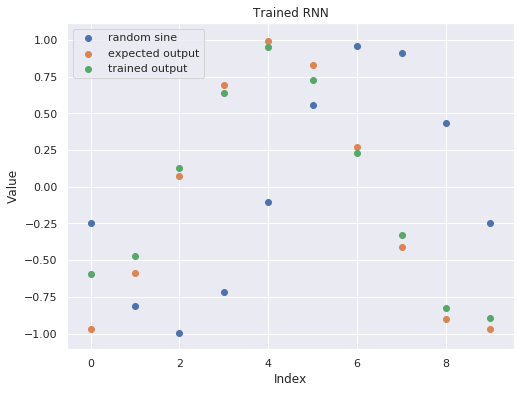

In [20]:
testOut = network.forward (torch.from_numpy (X[idx, :]).float ())

fig = plt.figure (figsize = (8, 6))
plt.scatter (t, X[idx, :], label = 'random sine')
plt.scatter (t, y[idx, :], label = 'expected output')
plt.scatter (t, testOut.detach ().numpy ().reshape (10,), label = 'trained output')
plt.xlabel ('Index')
plt.ylabel ('Value')
plt.title ('Trained RNN')
plt.legend (loc = 'best')
plt.show ()

It is evident that after 100 epochs, the network has achieved to produce sequential output close to the desired cosine. However, the results are mediocre. We observe that after an initial period of transition around 5 epochs long, the validation loss finds it harder and harder to decrease. This could be owed to the [vanishing gradient][vg] problem, and it is a good reason to opt for LSTM's or GRU's over RNN's.

### Step 9
The following code utilizes given function ```parser``` to read the files downloaded from [GitHub][gh] and then split the training data as requested.

As can be seen in the [documentation][doc], ```train_test_split``` actually functions in a stratified way.

[vg]: <https://en.wikipedia.org/wiki/Vanishing_gradient_problem>
[gh]: <https://github.com/Jakobovski/free-spoken-digit-dataset>

In [1]:
from src import parser
import numpy as np

path = '/home/cappadokes/Downloads/free-spoken-digit-dataset/recordings'
X_train, X_test, y_train, y_test, spk_train, spk_test = parser.parser (path)

Total wavs: 2000


For the requested stratified split, ```StratifiedShuffleSplit``` was borrowed from scikit-learn. The sets of indices are then sorted and NumPy ```take``` function uses them to extract the final training and validation datasets.

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.preprocessing import StandardScaler

sss = StratifiedShuffleSplit (n_splits = 1, train_size = 0.8)
indices = [(train_idx, val_idx) for train_idx, val_idx in sss.split (X_train, y_train)]
train_idx = indices[0][0]
val_idx = indices[0][1]
train_idx.sort ()
val_idx.sort ()

X_val = np.take (np.array (X_train), val_idx)
y_val = np.take (y_train, val_idx)
X_train = np.take (np.array (X_train), train_idx)
y_train = np.take (y_train, train_idx)

### Step 10
```pomegranate``` was downloaded and installed, as suggested by the exercise. Then, the provided ```hmm``` module was extended as follows:
- a function was written for automated, arbitrary-sized left-to-right transition matrix generation (```transInit```)
- the initial body of the module was divided in 2 functions:
    - ```magicMarkov``` initializes and trains the model
    - ```markovsAdvice``` infers the maximum log likelihood, as calculated by Viterbi's algorithm, for a given sequence

All of the code described above is pasted below:

```python
import numpy as np
from pomegranate import *

def transInit (n_states):
    """
    Returns a left-to-right transition matrix.
    """
    mat = np.double (np.random.rand (n_states, n_states))       # Initialization
    for i in range (n_states):
        sum = 0                                                 # Scan each row
        for j in range (n_states):
            if j < i:
                mat[i, j] = 0                                   # Left-to-right!
            sum += mat[i, j]
            if sum >= 1:                                        # Overflow?
                sum -= mat[i, j]
                if j == n_states - 1:
                    mat[i, j] = 1.0 - sum
                else:
                    mat[i, j] = np.random.uniform (0, 1.0 - sum)
                sum += mat[i, j]
            else:
                if j == n_states - 1:                           # Underflow?
                    mat[i, j] = 1.0 - sum + mat[i, j]
    return mat

def magicMarkov (X, n_states, n_mixtures, gmm = True):
    """
    Initializes and trains a Hidden Markov Model on X data. By default,
    a mixture of Gaussians is used as the emission distribution.
    """
    for i in range (len (X)):
        for j in range (len (X[i])):
            if i == 0 and j == 0:
                X_friendly = X[i][j]
            else:
                X_friendly = np.vstack (X[i][j])
    dists = [] # list of probability distributions for the HMM states
    if n_mixtures == 1:
        gmm = False
    for i in range(n_states):
        if gmm:
            a = GeneralMixtureModel.from_samples (MultivariateGaussianDistribution, \
                                                  n_mixtures, np.float_ (X_friendly))
        else:
            a = MultivariateGaussianDistribution.from_samples (np.float_ (X_friendly))
        dists.append(a)
    trans_mat = transInit (n_states) # your transition matrix
    starts = np.zeros (n_states) # your starting probability matrix
    starts[0] = 1
    ends = np.zeros (n_states) # your starting probability matrix
    ends[n_states - 1] = 1
    data = X.tolist ()    # your data: must be a Python list that contains: 2D lists with the
                # sequences (so its dimension would be num_sequences x seq_length x
                # feature_dimension). But be careful, it is not a numpy array, it is
                # a Python list (so each sequence can have different length)
    # Define the GMM-HMM
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends,           \
                                          state_names=['s{}'.format(i) for i in     \
                                          range(n_states)])
    model.bake ()
    # Fit the model
    model.fit(data, max_iterations=50)
    return model

def markovsAdvice (model, sample):
    # Predict a sequence
    # a sample sequence
    logp, _ = model.viterbi(sample) # Run viterbi algorithm and return
                                    # log-probability
    return logp
```

In [23]:
from src import hmm
import numpy as np

test_model = hmm.magicMarkov (X_train[y_train == 0], 5, 1)

The model is now initialized.

### Step 11
15 combinations of states-GMM components will be trained on the training data for each number, using the ```magicMarkov``` function of the previous step. The case of 1 state was discarded as degenerate. Based on ```pomegranate```'s [docs][dc] (see **Fitting** section), the [Baum-Welch][BW] algorithm is by default used upon invoking the ```fit``` method. Thus the training is indeed done via Expectation Maximization, and no further modifications on the code are needed.

[dc]: <https://pomegranate.readthedocs.io/en/latest/HiddenMarkovModel.html>
[BW]: <https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm>

In [24]:
models = []
for states in range (4):
    if states == 0:
        continue
    for mixtures in range (5):
        for nums in range (10):
            models.append (hmm.magicMarkov (X_train[y_train == nums], states + 1, mixtures + 1))

TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
TypeError: Cannot cast ufunc subtract output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


> As discussed [here][iss], the above warnings are owed to maintenance issues of ```pomegranate```, and do not seem to harm the models' accuracy.

[iss]: <https://github.com/slp-ntua/patreco-lab-support-19-20/issues/15>

### Step 12
With all of the candidate models now trained, the following are to be completed:
- measure the validation accuracy of all configurations (state/mixtures combinations)
- choose as final configuration that of the best-competing ensemble
- classify the test data with the best-competing ensemble

We want to be as sure as possible that our classifier has appropriately high variance and appropriately low bias. In other words, we don't want our model to underfit or overfit its training data. For this reason, we choose the model's final hyperparameters based on its performance in the unknown validation data.

This process helps in maximizing the model's generalization ability.

To carry over this step, we iterate over all produced models, bagged in sets of 10 (1 set per configuration). In each iteration, all utterances of the validation set are classified. In the end, we pick the model with the highest accuracy, and measure its performance on the test set. All this work is facilitated by the functions below:

```python
def ensembleSummon (models, states, mixtures):
    """
    Returns the ensemble for a particular configuration.
    """
    start = 10 * (mixtures - 1) + 50 * (states - 2)
    end = start + 10
    return models[start:end]

def markovsCouncil (models, seq):
    """
    Returns the ensemble's prediction
    """
    preds = np.zeros (10)
    for num in range (10):
        preds[num] = markovsAdvice (models[num], seq)
    return preds.argmax ()

def markovsScore (models, data, labels):
    """
    Returns the accuracy of an ensemble on some particular data.
    """
    all = labels.size
    corrects = 0
    for i in range (len (data)):
        if markovsCouncil (models, data[i]) == labels[i]:
            corrects += 1
    return corrects / all * 100
```

In [25]:
for states in range (4):
    if states == 0:
        continue
    for mixtures in range (5):
        ensemble = hmm.ensembleSummon (models, states + 1, mixtures + 1)
        score = hmm.markovsScore (ensemble, X_val, y_val)
        print (states + 1, 'states,', mixtures + 1, 'mixtures:', score)

2 states, 1 mixtures: 94.44444444444444
2 states, 2 mixtures: 94.72222222222221
2 states, 3 mixtures: 97.5
2 states, 4 mixtures: 98.33333333333333
2 states, 5 mixtures: 98.33333333333333
3 states, 1 mixtures: 96.38888888888889
3 states, 2 mixtures: 97.22222222222221
3 states, 3 mixtures: 98.33333333333333
3 states, 4 mixtures: 98.05555555555556
3 states, 5 mixtures: 98.33333333333333
4 states, 1 mixtures: 97.22222222222221
4 states, 2 mixtures: 97.22222222222221
4 states, 3 mixtures: 98.88888888888889
4 states, 4 mixtures: 98.05555555555556
4 states, 5 mixtures: 98.05555555555556


As expected, the model with the best performance is that with the maximum number of both states and mixtures. We note, however, that even the smallest model achieves more than $90\%$ accuracy.

Next, we measure its performance on the test set:

In [26]:
final_model = hmm.ensembleSummon (models, 4, 5)
print ('Performance on test set:', hmm.markovsScore (final_model, np.array (X_test), np.array (y_test)))

Performance on test set: 97.5


The model thus retains its performance on the test set. It is a reasonable result, since there is no apparent difference in the distribution generating the train, validation, and test data. They all come from the same initial dataset.

### Step 13
The following function was written in order to generate the confusion matrices:

```python
def markovsConfusion (models, data, labels):
    """
    Returns the confusion matrix.
    """
    conf = np.zeros ((10, 10))
    for i in range (len (data)):
        pred = markovsCouncil (models, data[i])
        conf[labels[i], pred] += 1
    return conf
```

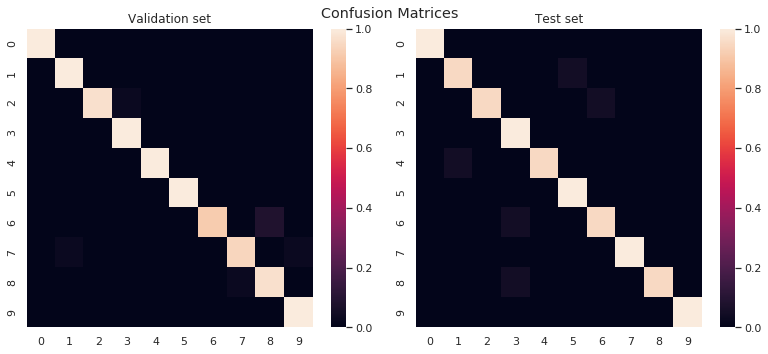

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set ()

fig = plt.figure (figsize = (11 ,5))
ax1 = fig.add_subplot (1, 2, 1)
ax1 = sns.heatmap (hmm.markovsConfusion (final_model, X_val, y_val))
ax1.set_title ('Validation set')
ax2 = fig.add_subplot (1, 2, 2)
ax2 = sns.heatmap (hmm.markovsConfusion (final_model, np.array (X_test), np.array (y_test)))
ax2.set_title ('Test set')
fig.tight_layout ()
fig.suptitle ('Confusion Matrices')
plt.show ()

The confusion matrices display a more detailed view of the already reported accuracy results. All of the digits are mostly correctly classified.

### Step 14
The data modelled with the HMM's will be reused here, with the same split as before.

A first step is to flesh out the ```Dataset``` class given. The code is transcribed below. The zero-padding allows sequences of variable length to be packed in tensors.

```python
class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        self.lengths = np.array ([len (seq) for seq in feats])
        self.feats = self.zero_pad_and_stack(np.array (feats))
        if isinstance(labels, (list, tuple)):
            self.labels = torch.tensor (labels)

    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        maxLen = self.lengths.max ()
        y = np.zeros ((len (x), maxLen, x[0].shape[-1]))
        for i in range (len (x)):
            if x[i].shape[0] < maxLen:
                diff = maxLen - x[i].shape[0]
                x[i] = np.vstack ((x[i], np.zeros ((diff, x[0].shape[-1]))))
            y[i, :, :] = x[i]
        return torch.from_numpy (y).type ('torch.FloatTensor')

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)
```

In [3]:
from src import lstm
from src import parser
import numpy as np

X_test = np.array (X_test)
y_test = np.array (y_test)

Next, we define the LSTM structure. All the possible variants of the network (number of layers, bidirectional, dropout) can be set upon initializing objects of the ```BasicLSTM``` class. We show below the 2 name methods, apart from the ones already given (```last_timestep``` etc.), which were not modified.

```python
class BasicLSTM(nn.Module):
    """
    Implements LSTM net, based on the inputs given.
        rnn_size: hidden layer width
        output_dim: number of classes
        num_layers, bidirectional: self-explanatory.
        dropout: probability of dropout
    """
    def __init__(self, input_dim, rnn_size, output_dim, num_layers,         \
                 bidirectional = False, dropout = 0):
        """
        Initializes network.
        """
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        # feature_size refers to the input vectors for the linear layers.
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size
        self.lstm = nn.LSTM (input_dim, rnn_size, num_layers,               \
                             batch_first = True, dropout = dropout,         \
                             bidirectional = self.bidirectional)
        # lin implements the layer just before the output.
        self.lin = nn.Linear (self.feature_size, output_dim)
        self.layers = num_layers
        # hidden marks the number of nodes in each LSTM's hidden layer.
        self.hidden = rnn_size

    def forward(self, x, lengths):
        """
        Returns LSTM final inferences for all sequences in batch x.
        """
        # h_0 initializes the hidden state. Dimensions according to the
        # documentation. Grad is set so that training can take place.
        h_0 = torch.zeros (self.layers * (1 + int (self.bidirectional)),    \
                           len (x), self.hidden).requires_grad_ ()
        # c_0 initializes the cell state.
        c_0 = h_0
        # both hidden and cell states are detached from the grad graph, so that
        # each batch is trained separately.
        out, (h_n, c_n) = self.lstm (x, (h_0.detach_ (), c_0.detach_ ()))
        # existing functions are used to isolate the outputs at the actual
        # endpoints of each sequence (sequence lengths are various)
        last_outputs = self.lin (self.last_timestep (out, lengths,          \
                                 self.bidirectional))
        return last_outputs
```

In [4]:
import torch
from torch.utils.data import DataLoader
from src import lstm

train_loader = DataLoader (lstm.FrameLevelDataset (X_train.tolist (), y_train.tolist ()), batch_size = len (X_train) // 50, shuffle = True)
# no point in either shuffling or batching the validation and train datasets.
val_loader = DataLoader (lstm.FrameLevelDataset (X_val.tolist (), y_val.tolist ()), batch_size = len (X_val), shuffle = False)
test_loader = DataLoader (lstm.FrameLevelDataset (X_test.tolist (), y_test.tolist ()), batch_size = len (X_test), shuffle = False)
# initialize a single-layer, unidirectional LSTM with 100 nodes in the hidden layer and size-10 output
# (since we perform classification, the output has as many nodes as the classes' number)
base_net = lstm.BasicLSTM (X_train[0].shape[-1], 25, 10, 1)

The net is now initialized. For its training, the following function was written:

```python
def fit (net, epochs, lr, loader, v_loader, L2 = 0, valTime = 5,            \
         showVal = False, earlyStopping = False):
    #Define loss function.
    loss_func = F.cross_entropy
    #Use Stochastic Gradient Descent of the optim package for parameter updates.
    opt = torch.optim.SGD (net.parameters (), lr = lr, weight_decay = L2)
    #A flag  for validation loss.
    old_valid_loss = -62
    old_net = net
    for epoch in range (epochs):
        epoch_loss = 0
        #It is wise, according to the documentation, to put the network in
        #training mode before each batch is loaded.
        net.train ()
        for xb, yb, lb in loader:
            out = net.forward (xb, lb)
            loss = loss_func (out, yb.type ('torch.LongTensor'))
            epoch_loss += loss
            #Backpropagate the loss.
            loss.backward ()
            #Update weights, bias.
            opt.step ()
            #A new batch is ready to be loaded. Clean gradient memory!
            opt.zero_grad ()
        print ('Train loss at epoch', epoch, ':', float (epoch_loss))
        #At the end of each epoch, the network is put in evaluation mode.
        net.eval ()
        # Will infer on the validation set (and maybe check for early       \
        # stopping) every earlyCheck epochs.
        if showVal and epoch % valTime == 0:
            #No reason to keep the gradient for the validation set.
            with torch.no_grad ():
                valid_loss = 0
                for xb, yb, lb in v_loader:
                    out = net.forward (xb, lb).view (1, -1)
                    valid_loss += loss_func (out, yb.type ('torch.LongTensor'))
                print ('Validation loss at epoch', epoch, ':',              \
                       float (valid_loss))
                #Early stopping!
                if old_valid_loss != -62 and valid_loss > old_valid_loss    \
                                         and earlyStopping:
                    # if the criterion is broken, pause training and return the
                    # previous logged net
                    net = old_net
                    print ('Training finished due to early stopping. Actual \
                           number of epochs:', epoch)
                    break
                old_valid_loss = valid_loss
                # If the validation has passed, keep the net logged!
                old_net = net
    return net
```

The important parts of the above are:
- it provides a universal interface for choosing epochs, learning rate, L2 regularization factor, and early stopping cycles
- it uses cross entropy as the loss function, which implicitly combines negative log likelihood and softmax activation function (appropriate since we are doing classification)
- the optimizer for the weight updates is picked to be the Stochastic Gradient Descent
- it provides the choice for early stopping every n epochs (not by default). If the criterion is passed successfully (that is, if the current performance on the validation set is better than last time), then the network is archived in case a violation occurs next time.

We next use the above to train our defined net for a total of 50 epochs:

In [30]:
trained_net = lstm.fit (base_net, 50, 0.1, train_loader, val_loader)

Train loss at epoch 0 : 118.88011169433594
Train loss at epoch 1 : 114.49253845214844
Train loss at epoch 2 : 104.7584457397461
Train loss at epoch 3 : 88.84109497070312
Train loss at epoch 4 : 75.52359771728516
Train loss at epoch 5 : 66.7929916381836
Train loss at epoch 6 : 59.96245193481445
Train loss at epoch 7 : 55.096553802490234
Train loss at epoch 8 : 50.362247467041016
Train loss at epoch 9 : 45.08834457397461
Train loss at epoch 10 : 41.18018341064453
Train loss at epoch 11 : 35.90597152709961
Train loss at epoch 12 : 32.24934387207031
Train loss at epoch 13 : 29.409008026123047
Train loss at epoch 14 : 25.224422454833984
Train loss at epoch 15 : 23.14230728149414
Train loss at epoch 16 : 20.9240665435791
Train loss at epoch 17 : 16.337574005126953
Train loss at epoch 18 : 17.683074951171875
Train loss at epoch 19 : 14.913033485412598
Train loss at epoch 20 : 13.626296997070312
Train loss at epoch 21 : 14.528273582458496
Train loss at epoch 22 : 34.28425598144531
Train loss a

/home/cappadokes/Desktop/phD/studyDen/courses/patrec/patrec19/labTwo/src/lstm.py:177: RuntimeWarning: invalid value encountered in true_divide
  val_losses = val_losses / val_losses.max ()


We observe that the network's performance on the training data was steadily improving up until approximately half of the total epochs. From there, it started fluctuating up and down. This fluctuation hints at reaching a local minimum of the loss function, and then randomly dancing around it. It could also hint at overfitting on some part of the data, some times small, some times large.

To further illuminate the situation, we now print the validation loss every 5 epochs:

In [31]:
base_net.__init__ (X_train[0].shape[-1], 25, 10, 1)
trained_net = lstm.fit (base_net, 50, 0.1, train_loader, val_loader, showVal = True)

Train loss at epoch 0 : 119.68755340576172
Validation loss at epoch 0 : 2.2619621753692627
Train loss at epoch 1 : 114.82783508300781
Train loss at epoch 2 : 105.84136962890625
Train loss at epoch 3 : 92.83598327636719
Train loss at epoch 4 : 81.11996459960938
Train loss at epoch 5 : 73.69252014160156
Validation loss at epoch 5 : 1.3378772735595703
Train loss at epoch 6 : 66.04920959472656
Train loss at epoch 7 : 59.784568786621094
Train loss at epoch 8 : 52.81178665161133
Train loss at epoch 9 : 46.42635726928711
Train loss at epoch 10 : 41.25916290283203
Validation loss at epoch 10 : 0.8037452101707458
Train loss at epoch 11 : 35.021244049072266
Train loss at epoch 12 : 29.177024841308594
Train loss at epoch 13 : 26.164676666259766
Train loss at epoch 14 : 28.690807342529297
Train loss at epoch 15 : 22.75212287902832
Validation loss at epoch 15 : 0.50626540184021
Train loss at epoch 16 : 19.15349578857422
Train loss at epoch 17 : 18.566974639892578
Train loss at epoch 18 : 17.5903682

The following conclusions can be derived from the above:
- no, it is not overfitting. Performance on the validation data keeps improving until the very end (with a minor exception).
- we should train for more epochs

We next add early stopping every 5 epochs. Early stopping is a practical way to avoid overfitting on the training data.

In [32]:
base_net.__init__ (X_train[0].shape[-1], 25, 10, 1)
trained_net = lstm.fit (base_net, 50, 0.1, train_loader, val_loader, showVal = True, earlyStopping = True)

Train loss at epoch 0 : 118.76834106445312
Validation loss at epoch 0 : 2.245645046234131
Train loss at epoch 1 : 113.75394439697266
Train loss at epoch 2 : 103.73694610595703
Train loss at epoch 3 : 88.44263458251953
Train loss at epoch 4 : 76.04854583740234
Train loss at epoch 5 : 67.65213775634766
Validation loss at epoch 5 : 1.2430872917175293
Train loss at epoch 6 : 62.604190826416016
Train loss at epoch 7 : 55.27700424194336
Train loss at epoch 8 : 48.29747772216797
Train loss at epoch 9 : 42.5484504699707
Train loss at epoch 10 : 36.519065856933594
Validation loss at epoch 10 : 0.6891953945159912
Train loss at epoch 11 : 33.35736846923828
Train loss at epoch 12 : 39.01245880126953
Train loss at epoch 13 : 32.929229736328125
Train loss at epoch 14 : 39.22301483154297
Train loss at epoch 15 : 26.897207260131836
Validation loss at epoch 15 : 0.6000047326087952
Train loss at epoch 16 : 21.709396362304688
Train loss at epoch 17 : 23.650888442993164
Train loss at epoch 18 : 21.6429691

The above is an example of the fluidity when training neural networks. There is no meaningful point in trying to tune the hyperparameters just for the sake of presenting nicer results.

Instead, we will use a second layer, use more neurons for the hidden state, also adding Dropout and L2 regularization. The dropout term probabilistically prunes weights, making the model smaller and less prone to overfitting. The L2 term adds a constraint as regards the size of the weights, complementing the dropout's functionality.

In [5]:
base_net.__init__ (X_train[0].shape[-1], 50, 10, 2, dropout = 0.25) 
trained_net = lstm.fit (base_net, 50, 0.1, train_loader, val_loader, L2 = 5e-3, showVal = True, earlyStopping = True)

Train loss at epoch 0 : 119.54357147216797
Validation loss at epoch 0 : 2.289447546005249
Train loss at epoch 1 : 118.8979721069336
Train loss at epoch 2 : 117.80345153808594
Train loss at epoch 3 : 114.94267272949219
Train loss at epoch 4 : 105.29329681396484
Train loss at epoch 5 : 88.85188293457031
Validation loss at epoch 5 : 1.5740886926651
Train loss at epoch 6 : 77.8609619140625
Train loss at epoch 7 : 72.18499755859375
Train loss at epoch 8 : 67.29414367675781
Train loss at epoch 9 : 62.01288604736328
Train loss at epoch 10 : 54.43502426147461
Validation loss at epoch 10 : 1.0483956336975098
Train loss at epoch 11 : 47.70757293701172
Train loss at epoch 12 : 40.69933319091797
Train loss at epoch 13 : 37.67472839355469
Train loss at epoch 14 : 33.6511344909668
Train loss at epoch 15 : 29.529020309448242
Validation loss at epoch 15 : 0.48886215686798096
Train loss at epoch 16 : 25.967193603515625
Train loss at epoch 17 : 27.334497451782227
Train loss at epoch 18 : 22.672687530517

The results are contradictive to intuition. The network managed to overfit, despite the dropout and L2. We assign this outcome to the hyperparameters of the problem.

>***IMPORTANT:*** When early stopping is invoked, the returned model is the one that lastly passed the criterion. This is why the results reported are not the ones in the end of each stream.

Finally, we implement a bidirectional LSTM, this time putting in everything we partially used until now. This new architecture learns at each timestep both from the past and from the future. Consider the case where our network has trouble distinguishing 'f' from 'n'. Then, in the case of 'five' and 'nine', it will have trouble providing the correct answer *if it is fed only with past parts of the sequence*. This is where the bidirectional set has an advantage.

In [6]:
base_net.__init__ (X_train[0].shape[-1], 50, 10, 2, dropout = 0.25, bidirectional = True) 
trained_net = lstm.fit (base_net, 50, 0.1, train_loader, val_loader, showVal = True, L2 = 5e-3, earlyStopping = True)

Train loss at epoch 0 : 119.47355651855469
Validation loss at epoch 0 : 2.2820305824279785
Train loss at epoch 1 : 118.008544921875
Train loss at epoch 2 : 115.41786193847656
Train loss at epoch 3 : 108.27996826171875
Train loss at epoch 4 : 88.44829559326172
Train loss at epoch 5 : 63.383060455322266
Validation loss at epoch 5 : 1.0171152353286743
Train loss at epoch 6 : 46.4764289855957
Train loss at epoch 7 : 36.80916213989258
Train loss at epoch 8 : 30.532732009887695
Train loss at epoch 9 : 26.26467514038086
Train loss at epoch 10 : 23.38579559326172
Validation loss at epoch 10 : 0.462748646736145
Train loss at epoch 11 : 21.29205322265625
Train loss at epoch 12 : 19.102983474731445
Train loss at epoch 13 : 17.582813262939453
Train loss at epoch 14 : 15.959891319274902
Train loss at epoch 15 : 14.619240760803223
Validation loss at epoch 15 : 0.31476089358329773
Train loss at epoch 16 : 14.087621688842773
Train loss at epoch 17 : 12.683021545410156
Train loss at epoch 18 : 11.71295

The improvements are obvious. The bidirectional LSTM achieves the best performance and the fastest convergence. Below we display the final requested results.

Accuracy on validation set: 92.22222222222223 %
Accuracy on test set: 92.0 %


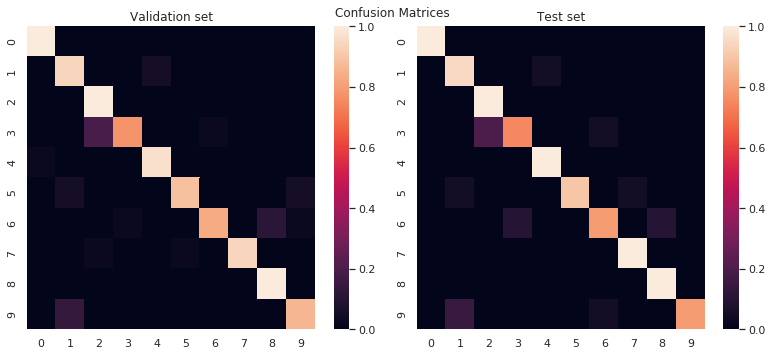

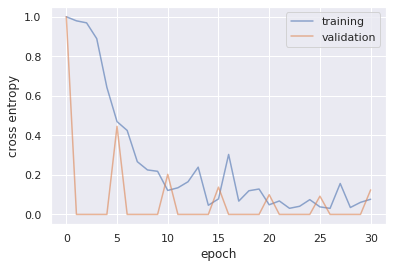

In [7]:
lstm.finalStuff (trained_net, val_loader, test_loader) 

As a final note, we once again emphasize the difficulty of training a neural network. We consider our configuration rather minimal: few neurons, small batches, few layers. It is not hard to imagine a configuration that surpasses the HMM's in performance.